<a href="https://colab.research.google.com/github/WHU-Peter/COMP6200-Project/blob/main/vgg_model_annealing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! /opt/bin/nvidia-smi

Sat Aug 21 07:07:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    54W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
import os
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import math
import numpy as np

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(seed)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=4,
                                          shuffle=True)
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=4,
                                         shuffle=False)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def softmax_temperature(logits, temperature):
    pro = F.softmax(logits / temperature, dim=-1)
    return pro;

In [5]:
class AnnealingLookUpTable(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int):
        super(AnnealingLookUpTable, self).__init__()
        self.embedding_dim = embedding_dim
        self.emb = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, x, temperature):
        if self.training:
          x = softmax_temperature(x, temperature)
          return x @ self.emb.weight
        else:
          # x = softmax_temperature(x, 0.00001)
          # x = mapping_onehot_vector(x)
          # return self.emb(x)

          x = softmax_temperature(x, temperature)
          nozero = torch.nonzero(x);
          out = np.zeros((x.shape[0], self.embedding_dim))
          out = torch.tensor(out).to(device)
          # print(np.array(nozero).shape[1])
          for i in range(x.shape[0]):
            idx = torch.where(nozero[:,0]==i)[0]
            rows = nozero[idx, 1].long()
            out[i] = torch.mean(self.emb(rows), axis=0)
          return out.float()

In [6]:
class Annealing_VGG_LookUpTable(nn.Module):
  def __init__(self, originalModel):
    super(Annealing_VGG_LookUpTable, self).__init__()
    # self.features = originalModel.features
    # self.avgpool = originalModel.avgpool
    self.vgg = nn.Sequential(*list(originalModel.children())[:-1])
    # self.classifier = originalModel.classifier
    self.look_up_table = AnnealingLookUpTable(25088, 4096)
    self.classifier = nn.Sequential(*list(originalModel.classifier.children())[1:])
    
  def forward(self, x, temperature):
    # x = self.features(x)
    # x = self.avgpool(x)
    x = self.vgg(x)
    x = x.view(x.size(0), -1)
    x = self.look_up_table(x, temperature)
    x = self.classifier(x)
    return x

In [7]:
pre_model = models.vgg16(pretrained=True)  # 使用VGG16 网络预训练好的模型
for parma in pre_model.parameters():  # 设置自动梯度为false
    parma.requires_grad = True
Annealing_lut_model = Annealing_VGG_LookUpTable(pre_model).to(device)

epoches = 30  #Training times
learning_rate = 1e-5  #Learning rate

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Annealing_lut_model.parameters(), lr=learning_rate)
Loss_Annealing_Model_exp = []
idx = 0

print('Loss_Annealing_Model Started Training')
for epoch in range(epoches):    #Iteration
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        idx = idx + 1
        inputs, labels = data
                 #Initialize gradient
        optimizer.zero_grad()
        outputs = Annealing_lut_model(inputs.to(device), torch.tensor(max(0.0001, math.exp(-1.4 * math.pow(10, -5) * idx)), device= device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # for parameter in optimizer.param_groups[0]['params']:
        #   print(np.any(parameter.grad.cpu().numpy()==0))

        # Print loss
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            Loss_Annealing_Model_exp.append(running_loss)
            running_loss = 0.0

print('Loss_Annealing_Model Finished Training')

Loss_Annealing_Model Started Training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 3.14771
[1,  4000] loss: 2.34918
[1,  6000] loss: 2.34055
[1,  8000] loss: 2.33426
[1, 10000] loss: 2.33270
[1, 12000] loss: 2.32458
[2,  2000] loss: 2.32285
[2,  4000] loss: 2.32143
[2,  6000] loss: 2.32133
[2,  8000] loss: 2.31889
[2, 10000] loss: 2.31556
[2, 12000] loss: 2.31515
[3,  2000] loss: 2.31481
[3,  4000] loss: 2.31354
[3,  6000] loss: 2.31333
[3,  8000] loss: 2.31175
[3, 10000] loss: 2.31311
[3, 12000] loss: 2.31000
[4,  2000] loss: 2.30645
[4,  4000] loss: 2.31018
[4,  6000] loss: 2.30920
[4,  8000] loss: 2.30883
[4, 10000] loss: 2.30924
[4, 12000] loss: 2.30744
[5,  2000] loss: 2.30837
[5,  4000] loss: 2.30736
[5,  6000] loss: 2.17031
[5,  8000] loss: 1.70402
[5, 10000] loss: 1.43958
[5, 12000] loss: 1.20283
[6,  2000] loss: 1.06267
[6,  4000] loss: 1.00648
[6,  6000] loss: 0.93727
[6,  8000] loss: 0.85255
[6, 10000] loss: 0.73028
[6, 12000] loss: 0.65753
[7,  2000] loss: 0.49543
[7,  4000] loss: 0.48776
[7,  6000] loss: 0.47412
[7,  8000] loss: 0.45261


In [ ]:
torch.save(Annealing_lut_model.state_dict(), "./Annealing_lut_model.weights")

In [9]:
pre_model = models.vgg16(pretrained=True)  # 使用VGG16 网络预训练好的模型
for parma in pre_model.parameters():  # 设置自动梯度为false
    parma.requires_grad = True
Annealing_lut_model = Annealing_VGG_LookUpTable(pre_model).to(device)

epoches = 30  #Training times
learning_rate = 1e-5  #Learning rate

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Annealing_lut_model.parameters(), lr=learning_rate)
Loss_Annealing_Model_Prop = []
idx = 0

print('Loss_Annealing_Model Started Training')
for epoch in range(epoches):    #Iteration
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        idx = idx + 1
        inputs, labels = data
                 #Initialize gradient
        optimizer.zero_grad()
        outputs = Annealing_lut_model(inputs.to(device), torch.tensor(max(0.0001, max(0.0001, math.pow(0.999859, idx/10))), device= device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # for parameter in optimizer.param_groups[0]['params']:
        #   print(np.any(parameter.grad.cpu().numpy()==0))

        # Print loss
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            Loss_Annealing_Model_Prop.append(running_loss)
            running_loss = 0.0

print('Loss_Annealing_Model Finished Training')

Loss_Annealing_Model Started Training
[1,  2000] loss: 3.11043
[1,  4000] loss: 2.17876
[1,  6000] loss: 1.78036
[1,  8000] loss: 1.62934
[1, 10000] loss: 1.37215
[1, 12000] loss: 1.22172
[2,  2000] loss: 1.03193
[2,  4000] loss: 1.00406
[2,  6000] loss: 0.91328
[2,  8000] loss: 0.72977
[2, 10000] loss: 0.65891
[2, 12000] loss: 0.59684
[3,  2000] loss: 0.45673
[3,  4000] loss: 0.44245
[3,  6000] loss: 0.41886
[3,  8000] loss: 0.42798
[3, 10000] loss: 0.42486
[3, 12000] loss: 0.41588
[4,  2000] loss: 0.27830
[4,  4000] loss: 0.27619
[4,  6000] loss: 0.28058
[4,  8000] loss: 0.27823
[4, 10000] loss: 0.28670
[4, 12000] loss: 0.26150
[5,  2000] loss: 0.16712
[5,  4000] loss: 0.19075
[5,  6000] loss: 0.17574
[5,  8000] loss: 0.18277
[5, 10000] loss: 0.18618
[5, 12000] loss: 0.19093
[6,  2000] loss: 0.10355
[6,  4000] loss: 0.11813
[6,  6000] loss: 0.12705
[6,  8000] loss: 0.12749
[6, 10000] loss: 0.13698
[6, 12000] loss: 0.11473
[7,  2000] loss: 0.07560
[7,  4000] loss: 0.08635
[7,  6000] l

In [10]:
pre_model = models.vgg16(pretrained=True)  # 使用VGG16 网络预训练好的模型
for parma in pre_model.parameters():  # 设置自动梯度为false
    parma.requires_grad = True
Annealing_lut_model = Annealing_VGG_LookUpTable(pre_model).to(device)

epoches = 30  #Training times
learning_rate = 1e-5  #Learning rate

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Annealing_lut_model.parameters(), lr=learning_rate)
Loss_Annealing_Model_linear = []
idx = 0

print('Loss_Annealing_Model Started Training')
for epoch in range(epoches):    #Iteration
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        idx = idx + 1
        inputs, labels = data
                 #Initialize gradient
        optimizer.zero_grad()
        outputs = Annealing_lut_model(inputs.to(device), torch.tensor(max(0.0001, 0.9999 - 0.033*epoch), device= device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # for parameter in optimizer.param_groups[0]['params']:
        #   print(np.any(parameter.grad.cpu().numpy()==0))

        # Print loss
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            print('[%d, %5d] temperature: %.5f' %
                  (epoch + 1, i + 1, max(0.0001, 0.9999 - 0.033*epoch)))
            Loss_Annealing_Model_linear.append(running_loss)
            running_loss = 0.0

print('Loss_Annealing_Model Finished Training')

Loss_Annealing_Model Started Training
[1,  2000] loss: 3.08882
[1,  2000] temperature: 0.99990
[1,  4000] loss: 2.34408
[1,  4000] temperature: 0.99990
[1,  6000] loss: 2.34030
[1,  6000] temperature: 0.99990
[1,  8000] loss: 2.33999
[1,  8000] temperature: 0.99990
[1, 10000] loss: 2.32942
[1, 10000] temperature: 0.99990
[1, 12000] loss: 2.32902
[1, 12000] temperature: 0.99990
[2,  2000] loss: 2.32802
[2,  2000] temperature: 0.96690
[2,  4000] loss: 2.32182
[2,  4000] temperature: 0.96690
[2,  6000] loss: 2.15810
[2,  6000] temperature: 0.96690
[2,  8000] loss: 1.69851
[2,  8000] temperature: 0.96690
[2, 10000] loss: 1.34304
[2, 10000] temperature: 0.96690
[2, 12000] loss: 1.18133
[2, 12000] temperature: 0.96690
[3,  2000] loss: 1.02457
[3,  2000] temperature: 0.93390
[3,  4000] loss: 0.98088
[3,  4000] temperature: 0.93390
[3,  6000] loss: 0.91810
[3,  6000] temperature: 0.93390
[3,  8000] loss: 0.85310
[3,  8000] temperature: 0.93390
[3, 10000] loss: 0.70510
[3, 10000] temperature: 0

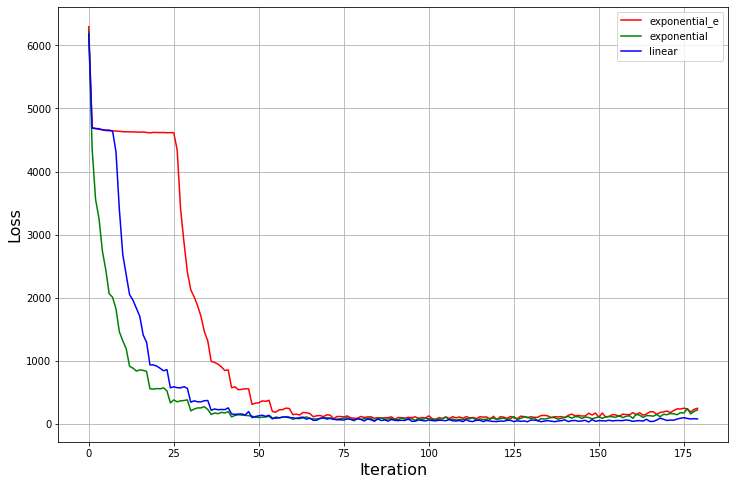

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(12,8))
ax.plot(Loss_Annealing_Model_exp, Color='red', label='exponential_e', markersize=16)
ax.plot(Loss_Annealing_Model_Prop, Color='green', label='exponential', markersize=16)
ax.plot(Loss_Annealing_Model_linear, Color='blue', label='linear', markersize=16)
ax.set_xlabel("Iteration", fontsize=16)
ax.set_ylabel("Loss", fontsize=16)
# ax.set_title("Linear Model", fontsize=16)
ax.grid()
ax.legend()
# ax.yaxis.set_major_locator(y_major_locator)
plt.show()

In [12]:
print(Loss_Annealing_Model_exp)

[6295.4160088300705, 4698.362445831299, 4681.099160313606, 4668.512912392616, 4665.40352332592, 4649.154500126839, 4645.708291292191, 4642.8637989759445, 4642.6537890434265, 4637.786241769791, 4631.127181529999, 4630.308316707611, 4629.626549243927, 4627.073973894119, 4626.6579077243805, 4623.503995895386, 4626.226335763931, 4620.009803056717, 4612.908445119858, 4620.35947227478, 4618.407818555832, 4617.662576675415, 4618.4861171245575, 4614.872433662415, 4616.73054933548, 4614.7221603393555, 4340.615003347397, 3408.0363912582397, 2879.1572725772858, 2405.6561209112406, 2125.3465134873986, 2012.9659889303148, 1874.5371485576034, 1705.1083010323346, 1460.5514042954892, 1315.0550528094172, 990.863434761297, 975.5274964037817, 948.2394827473909, 905.2119477665983, 846.7528409359511, 858.550159299979, 573.2552340372931, 588.3645126987249, 542.1010585740441, 548.3139305345248, 558.3395072179846, 556.7611744028982, 311.01018921949435, 329.15448177506914, 336.3068705199985, 365.6474192829337,

In [13]:
print(Loss_Annealing_Model_Prop)

[6220.854539632797, 4357.512228369713, 3560.7143238782883, 3258.6882833838463, 2744.3019897937775, 2443.440160661936, 2063.850209519267, 2008.1231438145041, 1826.5542283058167, 1459.5433863922954, 1317.8277175985277, 1193.670773955062, 913.462082920596, 884.8907753033563, 837.7196136526763, 855.9593238416128, 849.7270208965056, 831.7540355953388, 556.6059640741441, 552.3761584348977, 561.1651882429142, 556.4671341502108, 573.4008204466663, 522.9952387192752, 334.23353291267995, 381.49829956085887, 351.4878318324336, 365.54082414496224, 372.3614286106895, 381.86965760361636, 207.0965942578623, 236.2556466513779, 254.10093355245772, 254.98677541621146, 273.9518919768743, 229.46912388467172, 151.20215218178055, 172.70516892365413, 162.72984167112736, 183.50582504263002, 173.82667379720078, 195.64218519820133, 111.94436782556295, 135.27907845918526, 145.95666329300911, 141.37535232941445, 135.83692460513703, 130.86519827920347, 123.38699456820177, 107.96427598726041, 101.59184595567785, 10

In [14]:
print(Loss_Annealing_Model_linear)

[6177.63513982296, 4688.154862642288, 4680.595834970474, 4679.982576608658, 4658.844668149948, 4658.0486072301865, 4656.042840242386, 4643.63847887516, 4316.2015463113785, 3397.0152685046196, 2686.084766983986, 2362.6502960920334, 2049.1474898308516, 1961.7500022128224, 1836.1954694539309, 1706.1916274949908, 1410.197340078652, 1294.495565244928, 935.8000734616071, 935.2391139315441, 917.0666223624721, 881.0626139689703, 842.8628254611976, 859.8692125482485, 572.9436194796581, 588.9477559641236, 575.0998206199147, 571.2292809489882, 590.6300078561762, 563.8484839322045, 344.9473996211309, 366.9364054800826, 351.0408669330063, 350.98355356484535, 368.0944739432307, 371.7355560786091, 217.26770937783294, 237.94814313817187, 225.6872198242927, 229.97781399221276, 226.38184007268865, 255.30620852761422, 158.13169128586014, 152.08564721266885, 156.5181927769081, 158.22156277913746, 142.7848219147927, 196.10055373955765, 101.20282580216008, 118.48277791491637, 127.64937190130513, 138.5585107